In [3]:
!mamba install pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 0.6663000000119209 seconds
All requested packages already installed.


In [11]:
# 1. СОЗДАНИЕ ДАННЫХ 

print("="*80)
print("ЗАДАНИЕ 12: ОБЪЯСНИМОСТЬ МОДЕЛИ")
print("="*80)

np.random.seed(42)
n_samples = 200  # количество городов

# Генерируем координаты
x = np.random.uniform(0, 100, n_samples)
y = np.random.uniform(0, 100, n_samples)

# Генерируем признаки с пространственной структурой
# 1. Расстояние до дорог (чем ближе к центру, тем меньше)
dist_to_road = np.abs(x - 50) * 0.5 + np.abs(y - 50) * 0.3 + np.random.normal(0, 3, n_samples)
dist_to_road = np.abs(dist_to_road) + 1

# 2. Расстояние до реки
dist_to_river = np.minimum(
    np.abs(y - 30) * 0.8 + 5,
    np.abs(x - 70) * 0.6 + 8
) + np.random.normal(0, 4, n_samples)
dist_to_river = np.abs(dist_to_river) + 2

# 3. Высота над уровнем моря
elevation = 200 + 500 * np.exp(-((x-30)/30)**2 - ((y-60)/30)**2) + np.random.normal(0, 30, n_samples)
elevation = np.clip(elevation, 50, 800)

# 4. Плотность POI (логарифмическое распределение)
poi_density = np.random.lognormal(mean=1.5, sigma=0.8, size=n_samples)
poi_density = poi_density * (1 + 0.5 * np.exp(-dist_to_road/20))

# 5. Зелёный индекс
green_index = 0.3 + 0.5 * np.exp(-((x-50)/40)**2) + 0.1 * (elevation/1000) + np.random.normal(0, 0.1, n_samples)
green_index = np.clip(green_index, 0.1, 0.9)

# 6. Население
population = np.random.lognormal(mean=11, sigma=1.5, size=n_samples).astype(int)
population = np.clip(population, 1000, 3000000)

# 7. Индекс урбанизации
urban_idx = 0.2 + 0.6 * (np.log10(population) - 3) / 3 + 0.1 * (poi_density / 10)
urban_idx = np.clip(urban_idx + np.random.normal(0, 0.1, n_samples), 0, 1)

# Создаём DataFrame
df = pd.DataFrame({
    'dist_to_road': dist_to_road,
    'dist_to_river': dist_to_river,
    'elevation': elevation,
    'poi_density': poi_density,
    'green_index': green_index,
    'population': population,
    'urban_idx': urban_idx
})

# Создаём целевую переменную (жилой/нежилой)
# Жилой район, если высокая плотность POI, большое население, близко к дорогам
score = (0.3 * (poi_density > 5) + 
         0.3 * (population > 200000) + 
         0.2 * (dist_to_road < 15) + 
         0.2 * (green_index < 0.4))

# Добавляем случайный шум
score += np.random.normal(0, 0.1, n_samples)
y = (score > 0.5).astype(int)

df['target'] = y

print(f"\n ДАННЫЕ:")
print(f"   Количество объектов: {n_samples}")
print(f"   Количество признаков: {len(df.columns) - 1}")
print(f"   Распределение классов: 0 - {sum(y==0)}, 1 - {sum(y==1)}")

ЗАДАНИЕ 12: ОБЪЯСНИМОСТЬ МОДЕЛИ

 ДАННЫЕ:
   Количество объектов: 200
   Количество признаков: 7
   Распределение классов: 0 - 163, 1 - 37


In [12]:
# 2. ПРОСТАЯ МОДЕЛЬ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ВРУЧНУЮ)
# ============================================
print("\n" + "="*80)
print("ОБУЧЕНИЕ ПРОСТОЙ МОДЕЛИ")
print("="*80)

# Разделяем на обучающую и тестовую выборки (80/20)
np.random.seed(42)
indices = np.random.permutation(n_samples)
train_size = int(0.8 * n_samples)
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train = df.iloc[train_idx].drop('target', axis=1).copy()
X_test = df.iloc[test_idx].drop('target', axis=1).copy()
y_train = df.iloc[train_idx]['target'].copy()
y_test = df.iloc[test_idx]['target'].copy()

print(f"\n РАЗМЕРЫ ВЫБОРОК:")
print(f"   Обучающая выборка: {len(X_train)} объектов")
print(f"   Тестовая выборка: {len(X_test)} объектов")

# Нормализация признаков (для логистической регрессии)
X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

# Простая логистическая регрессия с градиентным спуском
class SimpleLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.losses = []
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for i in range(self.n_iterations):
            # Прямой проход
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)
            
            # Градиенты
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)
            
            # Обновление параметров
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            # Лосс (log loss)
            loss = -np.mean(y * np.log(y_pred + 1e-10) + (1-y) * np.log(1 - y_pred + 1e-10))
            self.losses.append(loss)
            
            if i % 200 == 0:
                print(f"   Итерация {i}, loss: {loss:.4f}")
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Обучаем модель
print("\n   Обучение модели...")
model = SimpleLogisticRegression(learning_rate=0.1, n_iterations=1000)
model.fit(X_train_norm.values, y_train.values)

# Предсказания
y_pred_proba = model.predict_proba(X_test_norm.values)
y_pred = model.predict(X_test_norm.values)

# Оценка качества
accuracy = np.mean(y_pred == y_test.values)
print(f"\n ТОЧНОСТЬ МОДЕЛИ:")
print(f"   Accuracy на тесте: {accuracy:.4f}")


ОБУЧЕНИЕ ПРОСТОЙ МОДЕЛИ

 РАЗМЕРЫ ВЫБОРОК:
   Обучающая выборка: 160 объектов
   Тестовая выборка: 40 объектов

   Обучение модели...
   Итерация 0, loss: 0.6931
   Итерация 200, loss: 0.3751
   Итерация 400, loss: 0.3656
   Итерация 600, loss: 0.3628
   Итерация 800, loss: 0.3617

 ТОЧНОСТЬ МОДЕЛИ:
   Accuracy на тесте: 0.8250


In [13]:
# 3. ВАЖНОСТЬ ПРИЗНАКОВ (ПЕРЕСТАНОВОЧНЫЙ МЕТОД)
# ============================================
print("\n" + "="*80)
print("ВАЖНОСТЬ ПРИЗНАКОВ (PERMUTATION IMPORTANCE)")
print("="*80)

def permutation_importance(model, X, y, feature_names, n_repeats=10):
    """
    Вычисление важности признаков методом перестановок
    """
    # Базовая точность
    y_pred_base = model.predict(X.values)
    base_accuracy = np.mean(y_pred_base == y.values)
    
    importance = {}
    importance_std = {}
    
    for feature_idx, feature in enumerate(feature_names):
        feature_importances = []
        
        for _ in range(n_repeats):
            # Копируем данные
            X_permuted = X.copy().values
            
            # Перемешиваем признак
            X_permuted[:, feature_idx] = np.random.permutation(X_permuted[:, feature_idx])
            
            # Точность с перемешанным признаком
            y_pred_perm = model.predict(X_permuted)
            perm_accuracy = np.mean(y_pred_perm == y.values)
            
            # Падение точности
            drop = base_accuracy - perm_accuracy
            feature_importances.append(drop)
        
        importance[feature] = np.mean(feature_importances)
        importance_std[feature] = np.std(feature_importances)
    
    return importance, importance_std

# Вычисляем важность признаков на тестовой выборке
print("\n   Вычисление важности признаков методом перестановок...")
importance, importance_std = permutation_importance(
    model, X_test_norm, y_test, 
    X_test.columns.tolist(), 
    n_repeats=10
)

# Сортируем по важности
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values()),
    'std': list(importance_std.values())
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\n ВАЖНОСТЬ ПРИЗНАКОВ:")
for idx, row in importance_df.iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f} ± {row['std']:.4f}")


ВАЖНОСТЬ ПРИЗНАКОВ (PERMUTATION IMPORTANCE)

   Вычисление важности признаков методом перестановок...


<class 'ValueError'>: assignment destination is read-only

In [17]:
# 4. ЛОКАЛЬНЫЕ ОБЪЯСНЕНИЯ (LIME-inspired)
# ============================================
print("\n" + "="*80)
print("ЛОКАЛЬНЫЕ ОБЪЯСНЕНИЯ (АНАЛИЗ КОНКРЕТНЫХ ПРИМЕРОВ)")
print("="*80)

def explain_prediction(model, X, y, idx, feature_names, X_train_mean, X_train_std):
    """
    Объяснение предсказания для конкретного объекта
    """
    print(f"\n   {'='*50}")
    print(f"   ОБЪЯСНЕНИЕ ДЛЯ ОБЪЕКТА {idx}")
    print(f"   {'='*50}")
    
    # Получаем объект (исправлено: используем loc вместо iloc для индексации по значению)
    x = X.loc[idx].copy()
    y_true_val = y.loc[idx]
    
    # Нормализуем для модели
    x_norm = (x - X_train_mean) / X_train_std
    
    # Предсказание модели
    proba = model.predict_proba(x_norm.values.reshape(1, -1))[0]
    pred = 1 if proba > 0.5 else 0
    
    print(f"\n   Истинный класс: {y_true_val} ({'жилой' if y_true_val==1 else 'нежилой'})")
    print(f"   Предсказание: {pred} (вероятность {proba:.4f})")
    print(f"   {'Совпадает' if pred == y_true_val else ' Ошибка'}")
    
    print(f"\n   Значения признаков:")
    for feature in feature_names:
        print(f"      {feature}: {x[feature]:.2f}")
    
    # Анализ влияния каждого признака
    print(f"\n   Влияние признаков на предсказание:")
    
    # Базовое предсказание (среднее)
    x_mean_norm = np.zeros(len(feature_names))
    base_proba = model.predict_proba(x_mean_norm.reshape(1, -1))[0]
    
    contributions = []
    for i, feature in enumerate(feature_names):
        # Создаём копию со средними значениями
        x_perturbed = x_mean_norm.copy()
        x_perturbed[i] = x_norm.iloc[i]
        
        # Вероятность с изменённым признаком
        perturbed_proba = model.predict_proba(x_perturbed.reshape(1, -1))[0]
        
        # Вклад признака
        contribution = perturbed_proba - base_proba
        contributions.append((feature, contribution, x[feature]))
    
    # Сортируем по абсолютному влиянию
    contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for feature, contribution, value in contributions:
        arrow = "↑" if contribution > 0 else "↓"
        print(f"      {arrow} {feature}: {contribution:+.4f} (значение={value:.2f})")

# Выбираем 3 случайных объекта для объяснения
np.random.seed(42)
explain_indices = np.random.choice(test_idx, size=min(3, len(test_idx)), replace=False)

for idx in explain_indices:
    explain_prediction(model, X_test_norm, y_test, idx, 
                      X_test.columns.tolist(), X_train_mean, X_train_std)



ЛОКАЛЬНЫЕ ОБЪЯСНЕНИЯ (АНАЛИЗ КОНКРЕТНЫХ ПРИМЕРОВ)

   ОБЪЯСНЕНИЕ ДЛЯ ОБЪЕКТА 193

   Истинный класс: 0 (нежилой)
   Предсказание: 1 (вероятность 0.9441)
    Ошибка

   Значения признаков:
      dist_to_road: -0.98
      dist_to_river: -0.11
      elevation: -0.02
      poi_density: -0.87
      green_index: 0.76
      population: 0.10
      urban_idx: 1.43

   Влияние признаков на предсказание:
      ↑ dist_to_road: +0.6734 (значение=-0.98)
      ↑ urban_idx: +0.4093 (значение=1.43)
      ↑ elevation: +0.1968 (значение=-0.02)
      ↓ poi_density: -0.0648 (значение=-0.87)
      ↓ green_index: -0.0355 (значение=0.76)
      ↓ dist_to_river: -0.0348 (значение=-0.11)
      ↓ population: -0.0279 (значение=0.10)

   ОБЪЯСНЕНИЕ ДЛЯ ОБЪЕКТА 129

   Истинный класс: 1 (жилой)
   Предсказание: 0 (вероятность 0.0815)
    Ошибка

   Значения признаков:
      dist_to_road: -1.52
      dist_to_river: -1.58
      elevation: -0.28
      poi_density: -0.33
      green_index: 0.44
      population: -0.49



АНАЛИЗ ВЗАИМОСВЯЗЕЙ МЕЖДУ ПРИЗНАКАМИ И ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

 КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
   poi_density: 0.2964 *** (p=0.0000)
   urban_idx: 0.2625 *** (p=0.0002)
   population: 0.2036 ** (p=0.0038)
   green_index: 0.0340  (p=0.6324)
   elevation: -0.0313  (p=0.6603)
   dist_to_river: -0.0893  (p=0.2088)
   dist_to_road: -0.1924 ** (p=0.0063)

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ


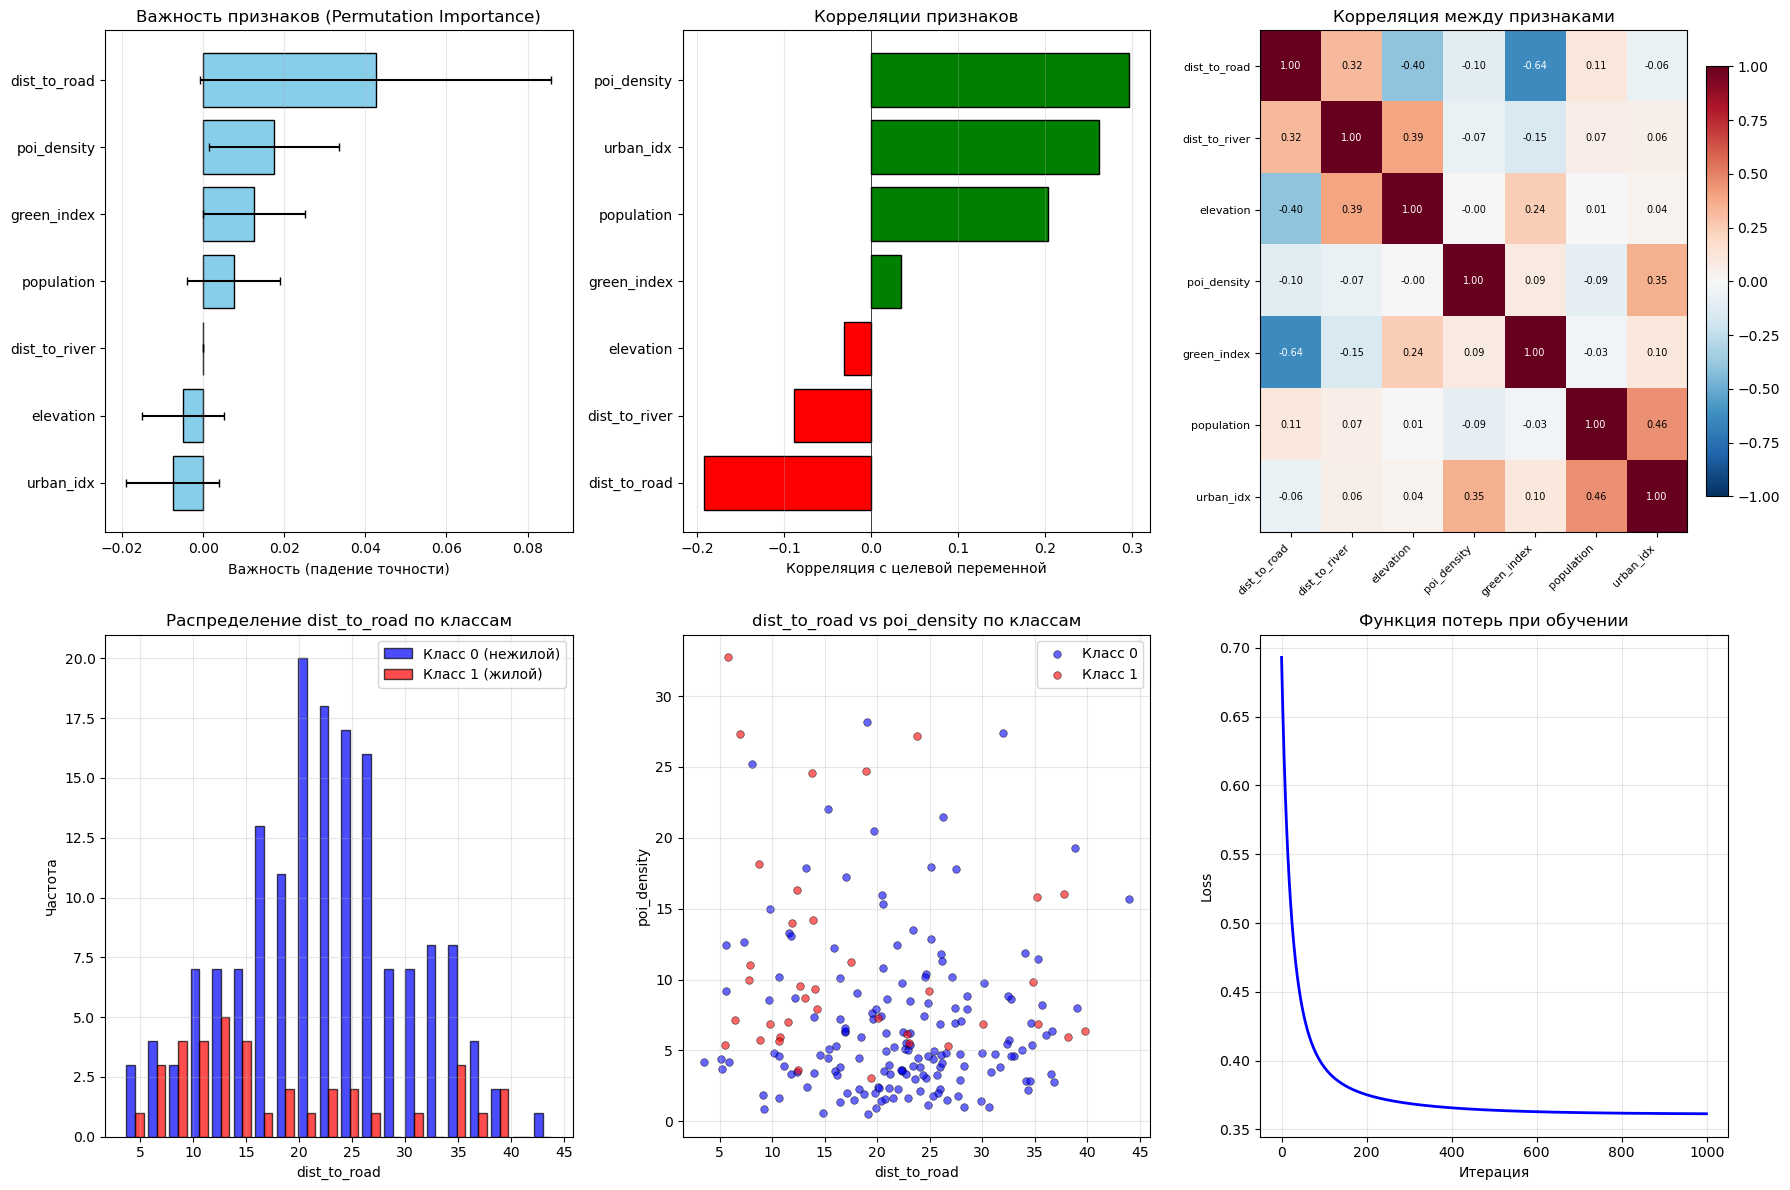

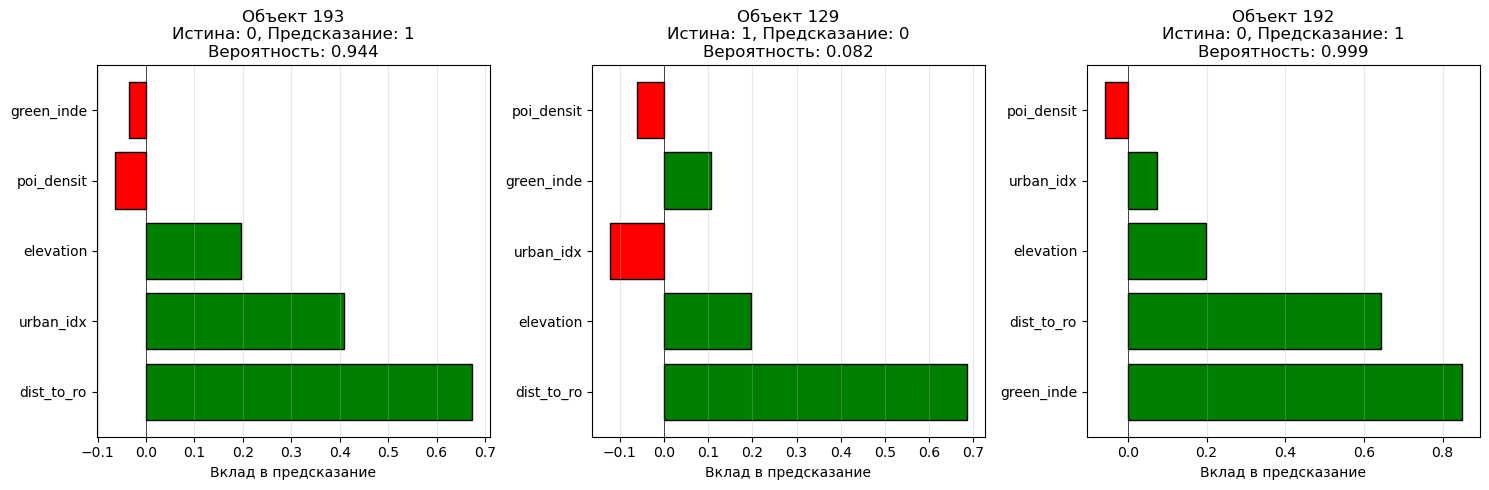

In [18]:
# 5. АНАЛИЗ ВЗАИМОСВЯЗЕЙ (КОРРЕЛЯЦИИ)

print("\n" + "="*80)
print("АНАЛИЗ ВЗАИМОСВЯЗЕЙ МЕЖДУ ПРИЗНАКАМИ И ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("="*80)

# Вычисляем корреляции с целевой переменной
correlations = []
for feature in X_train.columns:
    corr, p_value = pearsonr(df[feature], df['target'])
    correlations.append({
        'feature': feature,
        'correlation': corr,
        'p_value': p_value
    })

corr_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False).reset_index(drop=True)

print("\n КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
for idx, row in corr_df.iterrows():
    stars = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"   {row['feature']}: {row['correlation']:.4f} {stars} (p={row['p_value']:.4f})")

# 6. ВИЗУАЛИЗАЦИЯ

print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Важность признаков
ax = axes[0, 0]
ax.barh(importance_df['feature'], importance_df['importance'], 
        xerr=importance_df['std'], color='skyblue', edgecolor='black', capsize=3)
ax.set_xlabel('Важность (падение точности)')
ax.set_title('Важность признаков (Permutation Importance)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# 2. Корреляции с целевой переменной
ax = axes[0, 1]
colors = ['red' if c < 0 else 'green' for c in corr_df['correlation']]
ax.barh(corr_df['feature'], corr_df['correlation'], color=colors, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Корреляция с целевой переменной')
ax.set_title('Корреляции признаков')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# 3. Матрица корреляций признаков
ax = axes[0, 2]
corr_matrix = df.drop('target', axis=1).corr()
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(corr_matrix.columns, fontsize=8)
ax.set_title('Корреляция между признаками')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Добавляем значения корреляций
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.5 else "white", 
                      fontsize=7)

# 4. Распределение признаков по классам
ax = axes[1, 0]
feature_to_plot = importance_df.iloc[0]['feature']  # самый важный признак
class0_data = df[df['target'] == 0][feature_to_plot]
class1_data = df[df['target'] == 1][feature_to_plot]

ax.hist([class0_data, class1_data], bins=20, label=['Класс 0 (нежилой)', 'Класс 1 (жилой)'], 
        color=['blue', 'red'], alpha=0.7, edgecolor='black')
ax.set_xlabel(feature_to_plot)
ax.set_ylabel('Частота')
ax.set_title(f'Распределение {feature_to_plot} по классам')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Scatter plot двух самых важных признаков
ax = axes[1, 1]
feat1 = importance_df.iloc[0]['feature']
feat2 = importance_df.iloc[1]['feature'] if len(importance_df) > 1 else importance_df.iloc[0]['feature']

for target in [0, 1]:
    mask = df['target'] == target
    ax.scatter(df[mask][feat1], df[mask][feat2], 
               label=f'Класс {target}', alpha=0.6, s=30,
               color=['blue', 'red'][target], edgecolor='black', linewidth=0.5)

ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
ax.set_title(f'{feat1} vs {feat2} по классам')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Функция потерь при обучении
ax = axes[1, 2]
ax.plot(model.losses, 'b-', linewidth=2)
ax.set_xlabel('Итерация')
ax.set_ylabel('Loss')
ax.set_title('Функция потерь при обучении')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 7. ДОПОЛНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ

if len(explain_indices) > 0:
    fig, axes = plt.subplots(1, len(explain_indices), figsize=(5*len(explain_indices), 5))
    if len(explain_indices) == 1:
        axes = [axes]
    
    for i, idx in enumerate(explain_indices):
        ax = axes[i]
        
        # Получаем объект
        x = X_test_norm.loc[idx]
        y_true_val = y_test.loc[idx]
        
        # Нормализуем для модели
        x_norm = (x - X_train_mean) / X_train_std
        
        # Предсказание
        proba = model.predict_proba(x_norm.values.reshape(1, -1))[0]
        pred = 1 if proba > 0.5 else 0
        
        # Вычисляем вклады признаков
        x_mean_norm = np.zeros(len(X_test.columns))
        base_proba = model.predict_proba(x_mean_norm.reshape(1, -1))[0]
        
        contributions = []
        for j, feature in enumerate(X_test.columns):
            x_perturbed = x_mean_norm.copy()
            x_perturbed[j] = x_norm.iloc[j]
            perturbed_proba = model.predict_proba(x_perturbed.reshape(1, -1))[0]
            contribution = perturbed_proba - base_proba
            contributions.append((feature, contribution))
        
        # Сортируем и берём топ-5
        contributions.sort(key=lambda x: abs(x[1]), reverse=True)
        top_features = contributions[:5]
        
        # Строим график
        features = [f[0][:10] for f in top_features]
        values = [f[1] for f in top_features]
        colors_bar = ['green' if v > 0 else 'red' for v in values]
        
        y_pos = np.arange(len(features))
        ax.barh(y_pos, values, color=colors_bar, edgecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(features)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax.set_xlabel('Вклад в предсказание')
        ax.set_title(f'Объект {idx}\nИстина: {y_true_val}, Предсказание: {pred}\nВероятность: {proba:.3f}')
        ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()


